# River as a shapefile (raw format)

In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd

shapefile = gpd.read_file("edges.shp")
shapefile["rid"] = shapefile["rid"].astype(int)
shapefile.head()

,rid,netID,upDist,shreve,Length,addfunccol,geometry
0,1,1,1.000000,4.0,1.000000,1.00,"LINESTRING (0.00000 1.00000, 0.00000 0.00000)"
1,2,1,1.960106,1.0,0.960106,0.25,"LINESTRING (0.42592 1.86046, 0.00000 1.00000)"
2,3,1,1.980141,3.0,0.980141,0.75,"LINESTRING (0.16583 1.96601, 0.00000 1.00000)"
3,4,1,3.032648,1.0,1.052508,0.25,"LINESTRING (0.05008 3.01213, 0.16583 1.96601)"
4,5,1,3.072281,2.0,1.092141,0.50,"LINESTRING (0.75061 2.88840, 0.16583 1.96601)"


rid - unique identifier for river segment\
netID - river network ID, when dealing with multiple river outlets\
upDist - distance upstream from outlet (from the most upstream point on line)\
shreve - segment weighting based on Shreve's order\
addfunccol - additive function column, normalised shreve's order (used for weighting segments, a proxy for water volume)

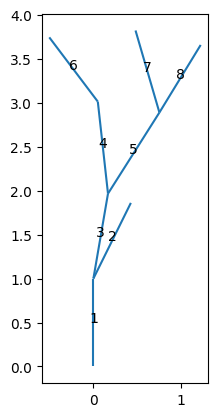

In [2]:
# edges (rid's)
ax = shapefile.plot()
shapefile.apply(
    lambda x: ax.annotate(text=x["rid"], xy=x.geometry.centroid.coords[0], ha="center"),
    axis=1,
)
plt.show()

In [3]:
# extract point information from shapely object: type(shapefile.geometry[0])
shapefile["points"] = shapefile.apply(lambda l: list(l["geometry"].coords), axis=1)
shapefile[["points_from", "points_to"]] = shapefile["points"].to_list()

# create a unique identifier for the start/end points of an edge
unique_locations = sorted(
    list(set([item for sublist in shapefile.points.to_list() for item in sublist]))
)
PID_GPT = {i: unique_locations[i] for i in range(len(unique_locations))}
GPT_PID = {v: k for k, v in PID_GPT.items()}

# map from geographic point, GPT, to unique node identifier, PID
shapefile["pid_from"] = shapefile["points_from"].apply(lambda x: GPT_PID[x])
shapefile["pid_to"] = shapefile["points_to"].apply(lambda x: GPT_PID[x])

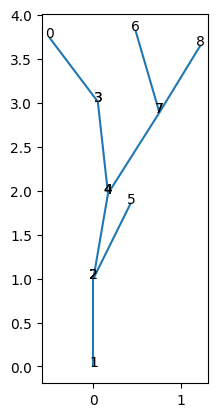

In [4]:
# node labels (pid's)
ax = shapefile.plot()
shapefile.apply(
    lambda x: ax.annotate(text=x["pid_from"], xy=x.points_from, ha="center"), axis=1
)
shapefile.apply(
    lambda x: ax.annotate(text=x["pid_to"], xy=x.points_to, ha="center"), axis=1
)
plt.show()

In [5]:
# neither of these functions are necessary, now I realise
def get_upstream_rids(row, df):
    upstream_rids = []
    up = df[df["pid_to"] == row["pid_from"]]

    while len(up) > 0:
        new_pids = list(up["pid_from"])
        upstream_rids.extend(up["rid"])
        up = df[df["pid_to"].isin(new_pids)]

    return upstream_rids


def calculate_on_left(df):
    grouped = df.groupby("pid_to")
    min_pid_from = grouped["pid_from"].transform("min")
    df["on_left"] = min_pid_from == df["pid_from"]
    return df

In [6]:
df = shapefile[
    ["rid", "upDist", "shreve", "Length", "addfunccol", "pid_from", "pid_to"]
].copy()

df["upstream_rids"] = df.apply(lambda x: get_upstream_rids(x, df), axis=1)
df = calculate_on_left(df)

## River domain representation (continuous)

In [7]:
pid = 1  # the outlet node
df.loc[df["pid_to"] == pid, ["parent_x_offset"]] = 0
df.loc[df["pid_to"] == pid, ["parent_width"]] = 1

from_pids_line_up = []
finished = False

while not finished:
    # of length either 1 or 2
    if len(df[df["pid_from"] == pid]) > 0:
        df.loc[df["pid_to"] == pid, "parent_x_offset"] = float(
            df[df["pid_from"] == pid]["x_offset"].iloc[0]
        )
        df.loc[df["pid_to"] == pid, "parent_width"] = float(
            df[df["pid_from"] == pid]["width"].iloc[0]
        )

    layer = df[df["pid_to"] == pid].copy()
    layer["pct"] = layer["addfunccol"] / layer["addfunccol"].sum()
    from_pids = layer["pid_from"]

    if len(from_pids) == 0:
        finished = len(from_pids_line_up) == 0
        if not finished:
            pid = from_pids_line_up.pop(0)
        continue

    # add percentage share of addfunccol at each branching confluence
    df.loc[df["pid_from"].isin(from_pids), ["width"]] = (
        layer["parent_width"] * layer["pct"]
    )

    # for the branch on left, then right
    df.loc[df["pid_from"] == min(from_pids), ["x_offset"]] = layer["parent_x_offset"]

    if len(from_pids) == 2:
        df.loc[df["pid_from"] == max(from_pids), ["x_offset"]] = float(
            layer["parent_x_offset"].iloc[0]
        ) + float(df.loc[df["pid_from"] == min(from_pids), ["width"]].squeeze())

    # get next pid's
    from_pids_line_up.extend(list(from_pids))
    finished = len(from_pids_line_up) == 0
    pid = from_pids_line_up.pop(0)

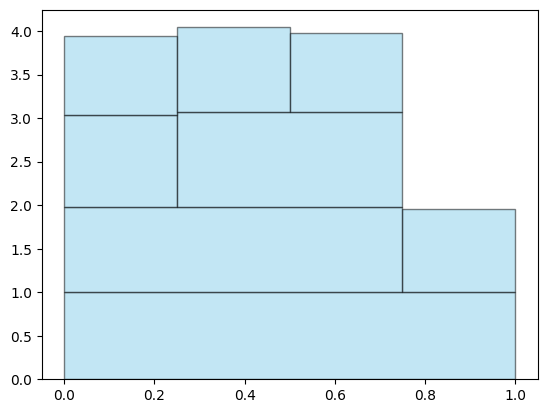

In [8]:
# plot bar
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for i, row in df.iterrows():
    ax.bar(
        row["x_offset"],
        height=row["Length"],
        bottom=row["upDist"] - row["Length"],
        width=row["addfunccol"],
        align="edge",
        color="skyblue",
        alpha=0.5,
        edgecolor="black",
    )

plt.show()

In [9]:
df

,rid,upDist,shreve,Length,addfunccol,pid_from,pid_to,upstream_rids,on_left,parent_x_offset,parent_width,width,x_offset
0,1,1.000000,4.0,1.000000,1.00,2,1,"[2, 3, 4, 5, 6, 7, 8]",True,0.00,1.00,1.00,0.00
1,2,1.960106,1.0,0.960106,0.25,5,2,[],False,0.00,1.00,0.25,0.75
2,3,1.980141,3.0,0.980141,0.75,4,2,"[4, 5, 6, 7, 8]",True,0.00,1.00,0.75,0.00
3,4,3.032648,1.0,1.052508,0.25,3,4,[6],True,0.00,0.75,0.25,0.00
4,5,3.072281,2.0,1.092141,0.50,7,4,"[7, 8]",False,0.00,0.75,0.50,0.25
5,6,3.948602,1.0,0.915953,0.25,0,3,[],True,0.00,0.25,0.25,0.00
6,7,4.044051,1.0,0.971769,0.25,6,7,[],True,0.25,0.50,0.25,0.25
7,8,3.972570,1.0,0.900289,0.25,8,7,[],False,0.25,0.50,0.25,0.50


In [10]:
# TODO: minus epsilon from side edges

##### River domain representation (as a shapely.Polygon object)

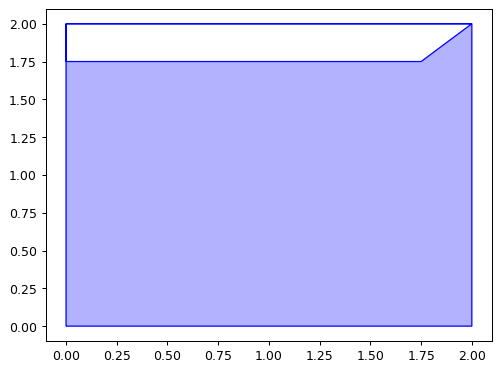

In [11]:
# create high-coverage continous domain representation
from shapely.geometry import Polygon
from shapely.plotting import plot_polygon, plot_points

fig = plt.figure(1, dpi=90)

# 1: valid polygon
ax = fig.add_subplot()

ext = [(0, 0), (0, 2), (2, 2), (2, 0), (0, 0)]
int = [(0, 2), (0, 1.75), (1.75, 1.75), (2, 2), (0, 2)]
polygon = Polygon(ext, [int])

plot_polygon(polygon, ax=ax, add_points=False, color="b")
plt.show()

In [12]:
polygon.length

12.353553390593273

In [13]:
list(polygon.interiors)

[<LINEARRING (0 2, 0 1.75, 1.75 1.75, 2 2, 0 2)>]

In [14]:
# TODO: figure out series of points that trace the boundary of this shape

## River as graph (NetworkX)

C:\Users\n10907700\AppData\Local\Temp\ipykernel_23724\1569939559.py:11: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(


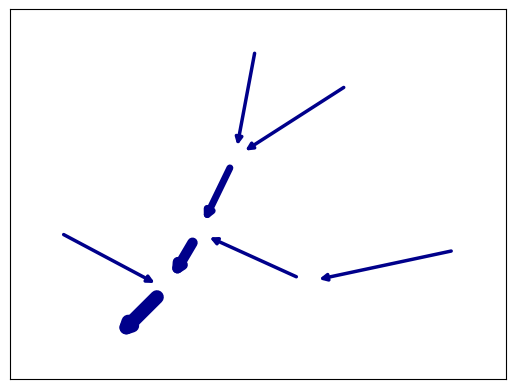

In [15]:
import networkx as nx

# encode as networkx object and plot
G = nx.DiGraph()
G.add_weighted_edges_from(
    list(zip(shapefile.pid_from, shapefile.pid_to, shapefile.addfunccol * 10))
)
# adding edges in the form: G.add_weighted_edges_from([(1, 2, 0.5), (3, 1, 1.75)])
pos = nx.spring_layout(G)
widths = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edges(
    G,
    pos,
    edgelist=widths.keys(),
    width=list(widths.values()),
    edge_color="darkblue",
    alpha=1,
)
plt.show()
# nodelist = G.nodes()
# nx.draw_networkx_nodes(G,pos,
#                        nodelist=nodelist,
#                        node_size=1500,
#                        node_color='black',
#                        alpha=0.7)
# nx.draw_networkx_labels(G, pos=pos,
#                         labels=dict(zip(nodelist,nodelist)),
#                         font_color='white')

# Generator

In [ ]:
# TODO: create generator onject on domain;
# - add points, calculate distance